In this notebook I will be examining the sentiment of the NBA headlines and tweets that were collected. Generally we should expect that the media will try to be neutral, but it's worth examining so that we might try to uncover if there is unfair bias levied against a certain player or team.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob, Word, Blobber
import flair
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer

In [48]:
sns.set_style('darkgrid')

In [3]:
#import data

#this data was cleaned in a separate notebook, only null rows and duplicated need to be dropped
headline_df = pd.read_csv('data/espn_df_recluster.csv')
tweet_df = pd.read_csv('data/nba_twitter.csv')

In [4]:
#preview ESPN headlines
headline_df.head()

,headlines,posted_time,tokens,labels,four_labels,five_labels
0,Wade matches King for 42nd on scoring list in win,2016-02-01,"['wade', 'match', 'king', '42nd', 'scoring', '...",0,3,3
1,"Chick Hearn's widow, Marge Hearn, dies at 98",2016-01-31,"['chick', 'hearns', 'widow', 'marge', 'hearn',...",0,3,3
2,Wittman to miss 2 games after brother's death,2016-01-31,"['wittman', 'miss', '2', 'game', 'brother', 'd...",0,3,3
3,LeBron atones for wardrobe mismatch vs. Spurs,2016-01-31,"['lebron', 'atones', 'wardrobe', 'mismatch', '...",0,3,4
4,Source: Rockets petition to rescind Howard's t...,2016-01-31,"['source', 'rocket', 'petition', 'rescind', 'h...",0,3,3


In [5]:
#preview Twitter data
tweet_df.head()

,date,tweet,source,tweet_tokens,dual_labels,trip_labels,quad_labels,five_labels
0,2021-02-26 12:35:27,Obi Toppin is expected to participate in the N...,Yahoo,"['obi', 'toppin', 'expected', 'participate', '...",0,0,3,1
1,2021-02-25 23:08:17,MPJ SLAM,Yahoo,"['mpj', 'slam', '']",1,2,1,2
2,2021-02-25 17:48:50,Timberwolves G Malik Beasley has been suspende...,Yahoo,"['timberwolves', 'g', 'malik', 'beasley', 'sus...",1,2,1,2
3,2021-02-25 13:40:20,Luka's game-winner against the Celtics vs. Luk...,Yahoo,"['lukas', 'gamewinner', 'celtic', 'v', 'lukas'...",1,2,2,2
4,2021-02-25 13:10:50,It's time to stop underrating the Utah Jazz Fr...,Yahoo,"['time', 'stop', 'underrating', 'utah', 'jazz'...",1,2,1,2


The below functions will be used to iterate through the list of headlines/tweets and count instances of players or teams. The `count_player_mentions` function will look for variations of a player's names. Fortunately, there are some unique names amongst NBA superstars but it is important to note that a more common name would require a more complex conditional statement.

In [6]:
def count_player_mentions(text):
    text_string = text
    
    lebron_count = 0
    curry_count = 0
    harden_count = 0
    kd_count = 0
    kyrie_count = 0
    dame_count = 0
    luka_count = 0
    zion_count = 0
    ja_count = 0
    giannis_count = 0
    jokic_count = 0
    embiid_count = 0
    cp3_count = 0
    
    if text_string.count('LeBron') > 0 or text_string.count('LBJ') > 0 or text_string.count('King James') > 0:
        lebron_count += 1
    
    if text_string.count('Curry') > 0 or text_string.count('Stephen') > 0 or text_string.count('Steph') > 0:
        curry_count += 1
    
    if text_string.count('James Harden') > 0 or text_string.count('Harden') > 0:
        harden_count += 1
        
    if text_string.count('Kevin Durant') > 0 or text_string.count('Durant') > 0 or text_string.count('KD') > 0:
        kd_count += 1
        
    if (text_string.count('Kyrie Irving') > 0 or text_string.count('Irving') > 0 
        or text_string.count('Kyrie') > 0):
        kyrie_count += 1
        
    if (text_string.count('Damian Lillard') > 0 or text_string.count('Lillard') > 0 
        or text_string.count('Dame') > 0):
        dame_count += 1
    
    if text_string.count('Luka Doncic') > 0 or text_string.count('Luka') > 0 or text_string.count('Doncic') > 0:
        luka_count += 1
        
    if (text_string.count('Zion Williamson') > 0 or text_string.count('Williamson') > 0 
        or text_string.count('Zion') >0):
        zion_count += 1
        
    if text_string.count('Ja Morant') > 0 or text_string.count('Morant') > 0 or text_string.count('Ja '):
        ja_count += 1
        
    if (text_string.count('Giannis') > 0 or text_string.count('Antetokounmpo') > 0 
        or text_string.count('Greek Freak') > 0):
        giannis_count += 1
    
    if (text_string.count('Nikola') > 0 or text_string.count('Jokic') > 0 
        or text_string.count('Joker') > 0):
        jokic_count += 1
    
    if (text_string.count('Joel')> 0 or text_string.count('Embiid') > 0):
        embiid_count += 1
        
    if (text_string.count('Chris Paul') > 0 or text_string.count('CP3') > 0):
        cp3_count += 1
        
    return [lebron_count, curry_count, harden_count, kd_count, 
            kyrie_count, dame_count, luka_count, zion_count, ja_count, 
            giannis_count, jokic_count, embiid_count, cp3_count]

In [7]:
def count_team_mentions(text):
    text_str = text
    
    atl_count = 0
    boston_count = 0
    brooklyn_count = 0
    charlotte_count = 0
    chicago_count = 0
    cleveland_count = 0
    dallas_count = 0
    denver_count = 0
    detroit_count = 0
    gsw_count = 0
    houston_count = 0
    indiana_count = 0
    clippers_count = 0
    lakers_count = 0
    memphis_count = 0
    miami_count = 0
    bucks_count = 0
    minn_count = 0
    pelicans_count = 0
    knicks_count = 0
    okc_count = 0
    orlando_count = 0
    philly_count = 0
    phoenix_count = 0
    portland_count = 0
    sac_count = 0
    spurs_count = 0
    raptors_count = 0
    utah_count = 0
    wizards_count = 0
    
    if text_str.count('Atlanta') > 0 or text_str.count('ATL') > 0 or text_str.count('Hawks') > 0:
        atl_count += 1
        
    if text_str.count('Boston') > 0 or text_str.count('Celtics') > 0:
        boston_count += 1
        
    if text_str.count('Brooklyn') > 0 or text_str.count('Nets') > 0:
        brooklyn_count += 1
        
    if text_str.count('Charlotte') > 0 or text_str.count('Hornets') > 0:
        charlotte_count += 1
        
    if text_str.count('Chicago') > 0 or text_str.count('Bulls') > 0 or text_str.count('Windy City') > 0:
        chicago_count += 1
        
    if text_str.count('Cleveland') > 0 or text_str.count('Cavaliers') > 0 or text_str.count('Cavs') > 0:
        cleveland_count += 1
        
    if text_str.count('Dallas') > 0 or text_str.count('Mavericks') > 0 or text_str.count('Mavs') > 0:
        dallas_count += 1
        
    if text_str.count('Denver') > 0 or text_str.count('Nuggets') > 0:
        denver_count += 1
        
    if text_str.count('Detroit') > 0 or text_str.count('Pistons') > 0 or text_str.count('Motor City') > 0:
        detroit_count += 1
        
    if text_str.count('Golden State') > 0 or text_str.count('Warriors') > 0 or text_str.count('GSW') > 0:
        gsw_count += 1
        
    if text_str.count('Houston') > 0 or text_str.count('Rockets') > 0 or text_str.count('H-Town') > 0:
        houston_count += 1
        
    if text_str.count('Indiana') > 0 or text_str.count('Pacers') > 0:
        indiana_count += 1
        
    if text_str.count('Clippers') > 0 or text_str.count('LAC') > 0 or text_str.count('Clips') > 0:
        clippers_count += 1
        
    if text_str.count('Lakers') > 0 or text_str.count('LAL') > 0:
        lakers_count += 1
        
    if text_str.count('Memphis') > 0 or text_str.count('Grizzlies') > 0:
        memphis_count += 1
        
    if text_str.count('Miami') > 0 or text_str.count('Heat') > 0:
        miami_count += 1
        
    if text_str.count('Milwaukee') > 0 or text_str.count('Bucks') > 0:
        bucks_count += 1
        
    if (text_str.count('Minnesota') > 0 or text_str.count('Timberwolves') > 0 or text_str.count("T'Wolves") > 0
       or text_str.count('Wolves') > 0):
        minn_count += 1
        
    if text_str.count('New Orleans') > 0 or text_str.count('Pelicans') > 0 or text_str.count('NOP') > 0:
        pelicans_count += 1
        
    if text_str.count('NYK') > 0 or text_str.count('Knicks') > 0 or text_str.count('New York') > 0:
        knicks_count += 1
        
    if (text_str.count('OKC') > 0 or text_str.count('Thunder') > 0 or 
        text_str.count('Oklahoma City Thunder')) > 0:
        okc_count += 1
        
    if text_str.count('Orlando') > 0 or text_str.count('Magic') > 0:
        orlando_count += 1
        
    if (text_str.count('Philadelphia') > 0 or text_str.count('76ers') > 0 or text_str.count('Sixers') > 0 
        or text_str.count('Philly') > 0):
        philly_count += 1
        
    if text_str.count('Phoenix') > 0 or text_str.count('Suns') > 0:
        phoenix_count += 1
        
    if text_str.count('Portland') > 0 or text_str.count('Trailblazers') > 0 or text_str.count('Blazers'):
        portland_count += 1
        
    if text_str.count('Sacramento') > 0 or text_str.count('Kings') > 0:
        sac_count += 1
        
    if text_str.count('San Antonio') > 0 or text_str.count('Spurs') > 0:
        spurs_count += 1
        
    if text_str.count('Toronto') > 0 or text_str.count('Raptors') > 0 or text_str.count('Jurassic Park') > 0:
        raptors_count += 1
        
    if text_str.count('Utah') > 0 or text_str.count('Jazz') > 0 or text_str.count('Salt Lake City') > 0:
        utah_count += 1
        
    if text_str.count('Washington') > 0 or text_str.count('Wizards') > 0 or text_str.count('DC') > 0:
        wizards_count += 1
        
    return [atl_count, boston_count, brooklyn_count, charlotte_count , chicago_count, cleveland_count,
            dallas_count, denver_count, detroit_count, gsw_count, houston_count, indiana_count,
            clippers_count, lakers_count, memphis_count, miami_count, bucks_count, minn_count, pelicans_count,
            knicks_count, okc_count, orlando_count, philly_count, phoenix_count, portland_count, sac_count,
            spurs_count, raptors_count, utah_count, wizards_count]

In [8]:
#drop duplicate rows
headline_df.drop_duplicates(inplace=True)
tweet_df.drop_duplicates(inplace=True)

#drop null rows for tweet/headline column
headline_df.dropna(subset=['headlines'], inplace=True)
tweet_df.dropna(subset=['tweet'], inplace=True)

In [9]:
#count player mentions from headlines and store informatiion into a dataframe
headline_list = list(headline_df['headlines'])

headline_player_mention_count = [count_player_mentions(x) for x in headline_list]

headline_player_mentions_df = pd.DataFrame(headline_player_mention_count, 
                                  columns=['LeBron', 'Steph', 'Harden', 'KD', 
                                           'Kyrie','Dame','Luka','Zion','Ja',
                                           'Giannis', 'Jokic', 'Embiid','CP'])

#count team mentions from headlines and store information into a dataframe
headline_team_mention_count = [count_team_mentions(x) for x in headline_list]

headline_team_mentions_df = pd.DataFrame(headline_team_mention_count, 
                                          columns=['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL','DEN', 
                                                 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 
                                                 'MIL', 'MIN', 'NOP', 'NYK', 'OKC','ORL', 'PHI', 'PHX', 
                                                 'POR', 'SAC', 'SAT', 'TOR', 'UTAH', 'WAS'])

In [10]:
#count player mentions from tweets and store information into a dataframe
tweet_list = list(tweet_df['tweet'])

tweets_player_mention_count = [count_player_mentions(y) for y in tweet_list]

tweets_player_mentions_df = pd.DataFrame(tweets_player_mention_count,
                                        columns=['LeBron', 'Steph', 'Harden', 'KD', 
                                           'Kyrie','Dame','Luka','Zion','Ja',
                                           'Giannis', 'Jokic', 'Embiid','CP'])

#count team mentions from tweets and store information into a dataframe
tweets_team_mention_count = [count_team_mentions(y) for y in tweet_list]

tweets_team_mentions_df = pd.DataFrame(tweets_team_mention_count, 
                                      columns=['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL','DEN', 
                                                 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 
                                                 'MIL', 'MIN', 'NOP', 'NYK', 'OKC','ORL', 'PHI', 'PHX', 
                                                 'POR', 'SAC', 'SAT', 'TOR', 'UTAH', 'WAS'])

In [11]:
headline_player_mentions_df.head()

,LeBron,Steph,Harden,KD,Kyrie,Dame,Luka,Zion,Ja,Giannis,Jokic,Embiid,CP
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
headline_player_mentions_df.sum().sort_values(ascending=False)

LeBron     1535
Steph       842
KD          750
Harden      643
Giannis     540
Kyrie       518
Embiid      434
Dame        341
Luka        282
Zion        236
Jokic       195
CP          162
Ja           73
dtype: int64

The biggest suprise in this list is obviously the low count for Chris Paul.  Chris Paul has been in the league since the 2005-2006 season and has been one of the top point guards over the course of his career. Oftentimes, we see players referred to by their last name, which would be 'Paul' in this case. However, if we chose to inclue the name 'Paul' in the conditional statement then we would need to have addtitional conditions where we don't count instances like "Paul George" or "Paul Millsap". Paul George and Paul Millsap are both excellent players who have played significant roles for their respective teams so it we would want to avoid overinflating the number of mentions for Chris Paul because of a common name.

What is not surprising here is that LeBron James and Stephen Curry lead the pack in terms of player mentions. LeBron has arguably been the best player in the league for more than a decade and Stephen Curry will likely go down as the greatest long distance shooter in the history of the NBA. Kevin Durant's decision to join the Golden State Warriors was highly polarizing and garnered much discussed in the summer of 2016. I started collecting data in January of 2016, so we could expect to see Kevin Durant mentioned many times because of his free agency decision in addition to his stellar play. 


In [13]:
headline_player_names = list(headline_player_mentions_df.sum().index)

Text(0.5, 1.0, 'Player Mentions in ESPN Headlines')

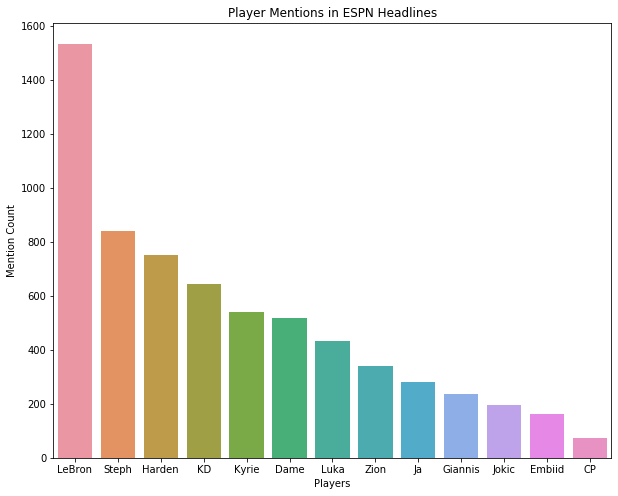

In [14]:
plt.figure(figsize=(10,8))
sns.barplot(x=headline_player_names, y=headline_player_mentions_df.sum().sort_values(ascending=False).values)
plt.xlabel('Players')
plt.ylabel('Mention Count')
plt.title('Player Mentions in ESPN Headlines')

In [15]:
headline_team_mentions_df.head()

,ATL,BOS,BKN,CHA,CHI,CLE,DAL,DEN,DET,GSW,...,OKC,ORL,PHI,PHX,POR,SAC,SAT,TOR,UTAH,WAS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
headline_team_mentions_df.sum().sort_values(ascending=False)

GSW     2064
CLE     1917
LAL     1814
BOS     1601
HOU     1496
PHI     1417
LAC     1323
TOR     1318
OKC     1304
MIL     1301
NYK     1250
MIA     1246
SAT     1240
CHI     1239
UTAH    1175
BKN     1142
POR     1130
NOP     1121
ATL     1096
DAL     1091
DEN     1088
SAC     1070
ORL     1065
IND     1049
MIN     1043
PHX     1034
DET     1034
WAS     1021
MEM      984
CHA      921
dtype: int64

There isn't too much that is surprising in terms of team mentions.  The most successful teams are the ones most mentioned by the media as well as teams that are in big markets. The smallest market teams that stand out to me are Cleveland and Oklahoma City.  Cleveland made the NBA Finals four straight seasons and won their first championship in June 2016. Oklahoma City was in the top half of team mentions for a variety of reasons:
- Kevin Durant's departure in 2016 caused lots of discussion
- The lack of success of the big 3 of Russell Westbrook, Paul George, and Carmelo Anthony
- The unexpected success of the Thunder in the 2019-2020 season, led by Chris Paul

The New York Knicks are a big market team but were subpar in terms of performance (prior to the 20-21 season). Their inability to make the playoffs and their often maligned owner likely helped drive their numbers up.

In [17]:
#create list of team names based on espn headlines
headline_team_names = list(headline_team_mentions_df.sum().sort_values(ascending=False).index)

In [18]:
team_colors = {'GSW':'gold', 'LAL':'blueviolet', 'CLE':'maroon', 'BOS':'green', 
               'HOU':'red', 'PHI':'mediumblue', 'TOR':'darkviolet', 'NYK':'darkorange', 
               'OKC':'dodgerblue', 'LAC':'mediumblue', 'SAT':'dimgray', 'MIA':'red', 
               'MIL':'darkolivegreen', 'CHI':'red', 'BKN':'black', 'WAS':'navy', 
               'MIN':'limegreen', 'NOP':'darkred', 'ORL':'blue', 'POR':'red', 
               'DAL':'mediumblue', 'ATL':'red', 'SAC':'purple', 'PHX':'orange', 
               'UTAH':'sandybrown', 'IND':'yellow', 'DEN':'deepskyblue', 
               'MEM':'midnightblue', 'DET':'red', 'CHA':'darkcyan'}

Text(0.5, 1.0, 'Most Mentioned Teams in ESPN Headlines')

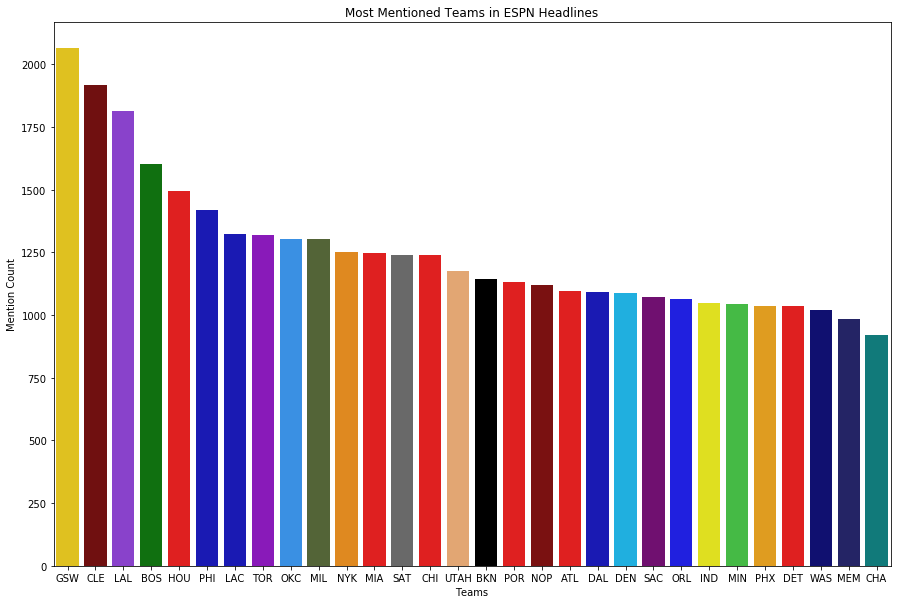

In [19]:
plt.figure(figsize=(15,10))
sns.barplot(x=headline_team_names, 
            y=headline_team_mentions_df.sum().sort_values(ascending=False).values,
           palette=team_colors)
plt.xlabel('Teams')
plt.ylabel('Mention Count')
plt.title('Most Mentioned Teams in ESPN Headlines')

In [20]:
tweets_player_mentions_df.head()

,LeBron,Steph,Harden,KD,Kyrie,Dame,Luka,Zion,Ja,Giannis,Jokic,Embiid,CP
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
tweets_player_mentions_df.sum().sort_values(ascending=False)

LeBron     6654
KD         3447
Steph      3363
Kyrie      1905
Harden     1695
Giannis    1531
Embiid     1116
CP          991
Zion        926
Dame        864
Luka        753
Jokic       561
Ja          252
dtype: int64

When looking at player mentions in the collected tweets, it appears that Chris Paul is better represented.  Ja Morant is the least mentioned, which meets our expectations given his lack of time in the league and how his peer in Zion Williamson was a more highlty touted player.  Kevin Durant barely edges out Stephen Curry, likely due to his free agency decisions in 2016 and 2019. Stephen Curry was injured for most of the 2019-2020 season but despite not being able to play, he still garnered a lot of attention.

In [22]:
twitter_player_names = list(tweets_player_mentions_df.sum().sort_values(ascending=False).index)

Text(0.5, 1.0, 'Player Mentions in Tweets from Various NBA Media Outlets')

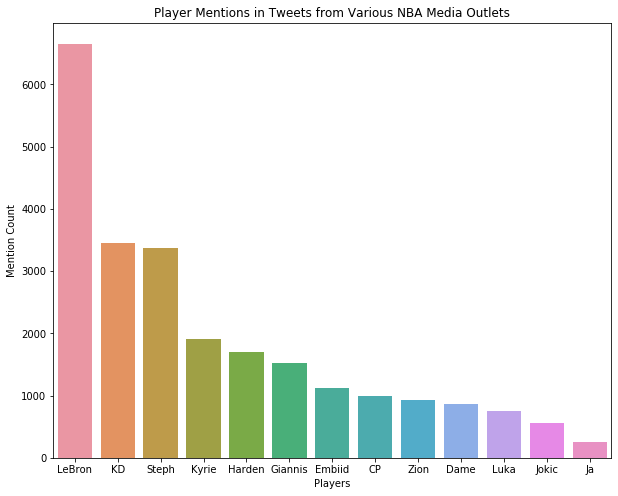

In [23]:
plt.figure(figsize=(10,8))
sns.barplot(x=twitter_player_names, y=tweets_player_mentions_df.sum().sort_values(ascending=False).values)
plt.xlabel('Players')
plt.ylabel('Mention Count')
plt.title('Player Mentions in Tweets from Various NBA Media Outlets')

In [24]:
tweets_team_mentions_df.head()

,ATL,BOS,BKN,CHA,CHI,CLE,DAL,DEN,DET,GSW,...,OKC,ORL,PHI,PHX,POR,SAC,SAT,TOR,UTAH,WAS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
tweets_team_mentions_df.sum()

ATL     1106
BOS     2787
BKN     1402
CHA      712
CHI     1421
CLE     3871
DAL     1117
DEN      915
DET      745
GSW     5922
HOU     2471
IND      920
LAC     1786
LAL     3954
MEM      804
MIA     1677
MIL     1441
MIN     1222
NOP     1200
NYK     2186
OKC     1990
ORL     1172
PHI     2313
PHX     1043
POR     1128
SAC     1075
SAT     1678
TOR     2237
UTAH    1023
WAS     1296
dtype: int64

In [26]:
#create list of sorted team names based on tweets
twitter_team_names = list(tweets_team_mentions_df.sum().sort_values(ascending=False).index)

Text(0.5, 1.0, 'Most Mentioned Teams in Tweets from Various NBA Media Outlets')

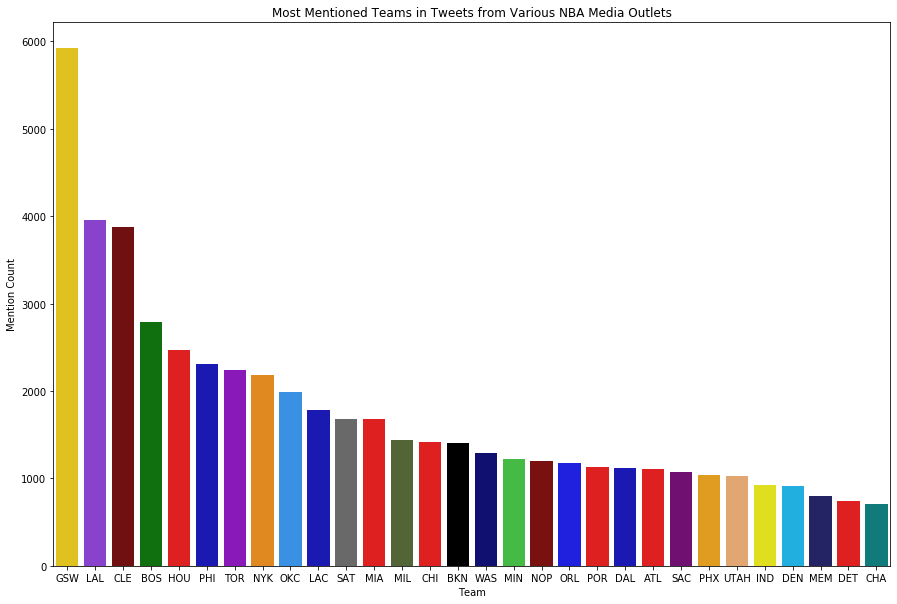

In [28]:
plt.figure(figsize=(15,10))
sns.barplot(x=twitter_team_names, 
            y=tweets_team_mentions_df.sum().sort_values(ascending=False).values, 
           palette=team_colors)
plt.xlabel('Team')
plt.ylabel('Mention Count')
plt.title('Most Mentioned Teams in Tweets from Various NBA Media Outlets')

The team mentions are nearly identical to that of the ESPN headlines. Teams in big markets and with high winning percentages dominate the tweets from NBA media.

In [26]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

In [27]:
headline_df.loc[3456, 'headlines']

'Rockets look for repeat against Mavericks'

In [28]:
#NLTK sentiment
sia_ = SentimentIntensityAnalyzer()
test_string_headline = headline_df.loc[3456, 'headlines']
sia_.polarity_scores(test_string_headline)



{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [29]:
#TextBlob Sentiment
TextBlob(test_string_headline).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [30]:
def calc_nltk_sentiment(string):
    """Returns compound polarity score using SentimentIntensityAnalyzer from NLTK."""
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(string)['compound']

In [31]:
def calc_textblob_sentiment(string):
    """Caclulates sentiment polarity using TextBlob library."""
    return TextBlob(string).sentiment.polarity

In [32]:
headline_nltk_vals = [calc_nltk_sentiment(x) for x in headline_list]
headline_blob_vals = [calc_textblob_sentiment(x) for x in headline_list]

In [33]:
tweets_nltk_vals = [calc_nltk_sentiment(x) for x in tweet_list]
tweets_blob_vals = [calc_textblob_sentiment(x) for x in tweet_list]

In [36]:
#create new columns with sentiment values for headlines and tweets
headline_df['nltk_sentiment'] = headline_nltk_vals
headline_df['textblob_sentiment'] = headline_blob_vals

tweet_df['nltk_sentiment'] = tweets_nltk_vals
tweet_df['textblob_sentiment'] = tweets_blob_vals

In [37]:
headline_df.head()

,headlines,posted_time,tokens,labels,four_labels,five_labels,nltk_sentiment,textblob_sentiment
0,Wade matches King for 42nd on scoring list in win,2016-02-01,"['wade', 'match', 'king', '42nd', 'scoring', '...",0,3,3,0.5859,0.8
1,"Chick Hearn's widow, Marge Hearn, dies at 98",2016-01-31,"['chick', 'hearns', 'widow', 'marge', 'hearn',...",0,3,3,0.0000,0.0
2,Wittman to miss 2 games after brother's death,2016-01-31,"['wittman', 'miss', '2', 'game', 'brother', 'd...",0,3,3,-0.6705,0.0
3,LeBron atones for wardrobe mismatch vs. Spurs,2016-01-31,"['lebron', 'atones', 'wardrobe', 'mismatch', '...",0,3,4,0.0000,0.0
4,Source: Rockets petition to rescind Howard's t...,2016-01-31,"['source', 'rocket', 'petition', 'rescind', 'h...",0,3,3,0.0000,0.0


Text(0.5, 1.0, 'TextBlob Sentiment Polarity Histogram')

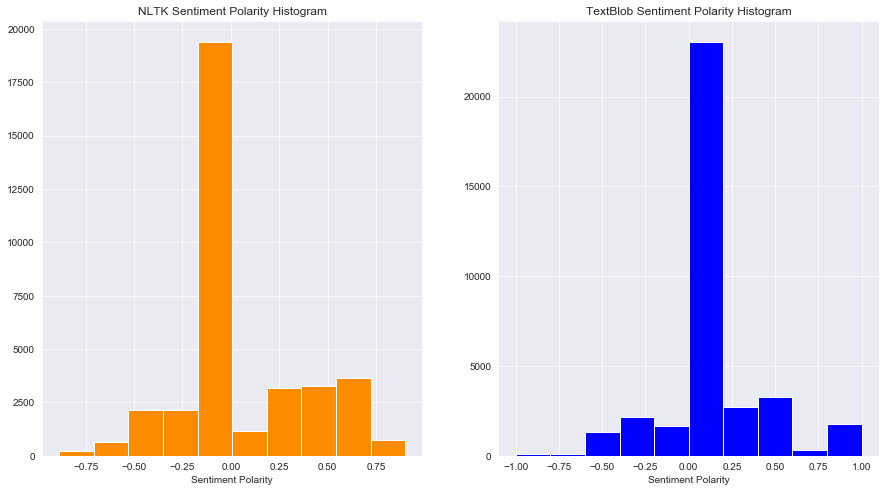

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].hist(x=headline_df['nltk_sentiment'], color='darkorange');
axs[1].hist(x=headline_df['textblob_sentiment'], color='blue');

axs[0].set_xlabel('Sentiment Polarity')
axs[0].set_title('NLTK Sentiment Polarity Histogram for Headlines')
axs[1].set_xlabel('Sentiment Polarity')
axs[1].set_title('TextBlob Sentiment Polarity Histogram for Headlines')

The sentiment polarity of headlines when using NLTK and TextBlob meets our expectations. The data is centered around 0, which means that ESPN headlines tend to be neutral. The polarity scale for both libraries ranges from -1 to 1 so I will append the the sentiment scores to the dataframes for both players and teams to see if we can identify any specific biases.

In [38]:
tweet_df.head()

,date,tweet,source,tweet_tokens,dual_labels,trip_labels,quad_labels,five_labels,nltk_sentiment,textblob_sentiment
0,2021-02-26 12:35:27,Obi Toppin is expected to participate in the N...,Yahoo,"['obi', 'toppin', 'expected', 'participate', '...",0,0,3,1,-0.3818,-0.100
1,2021-02-25 23:08:17,MPJ SLAM,Yahoo,"['mpj', 'slam', '']",1,2,1,2,-0.3818,0.000
2,2021-02-25 17:48:50,Timberwolves G Malik Beasley has been suspende...,Yahoo,"['timberwolves', 'g', 'malik', 'beasley', 'sus...",1,2,1,2,-0.6369,-0.125
3,2021-02-25 13:40:20,Luka's game-winner against the Celtics vs. Luk...,Yahoo,"['lukas', 'gamewinner', 'celtic', 'v', 'lukas'...",1,2,2,2,0.0000,0.000
4,2021-02-25 13:10:50,It's time to stop underrating the Utah Jazz Fr...,Yahoo,"['time', 'stop', 'underrating', 'utah', 'jazz'...",1,2,1,2,-0.2960,0.000


Text(0.5, 1.0, 'TextBlob Sentiment Polarity Histogram for NBA Media Tweets')

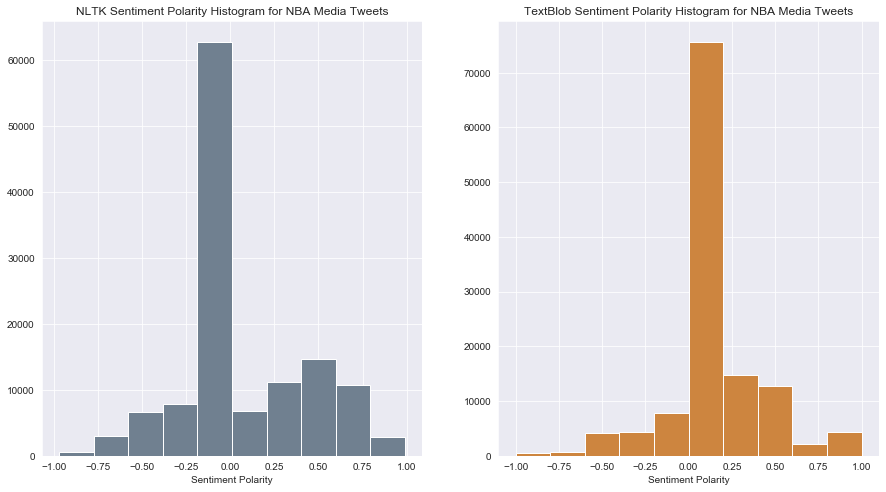

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].hist(x=tweet_df['nltk_sentiment'], color='slategray')
axs[1].hist(x=tweet_df['textblob_sentiment'], color='peru')

axs[0].set_xlabel('Sentiment Polarity')
axs[0].set_title('NLTK Sentiment Polarity Histogram for NBA Media Tweets')
axs[1].set_xlabel('Sentiment Polarity')
axs[1].set_title('TextBlob Sentiment Polarity Histogram for NBA Media Tweets')

The polarity score for the scraped tweets is also centered around 0 for each respective library. It's important to note that although we should expect these media sources to be fairly neutral, lots of context is missing by solely analyzing the text of a tweet. I chose to remove all non-ASCII characters and URLs. Non-ASCII characters like emojis wouldn't be interpreted by either of these libraries, but we as humans can quickly determine the sentiment that might be associated with an emoji.  The URLs included in scraped tweet data may have been an image, GIF, video, or another tweet (in the case of quoted tweets). We would have to develop an entirely separate model to try and interpret the data that might be linked to the URL and then translate that data into words that could easily be scored by NLTK or TextBlob. 

In [29]:
tweets_team_mentions_df['source'] = tweet_df['source']
tweets_player_mentions_df['source'] = tweet_df['source']

In [30]:
tweets_team_mentions_df.groupby('source').sum()

,ATL,BOS,BKN,CHA,CHI,CLE,DAL,DEN,DET,GSW,...,OKC,ORL,PHI,PHX,POR,SAC,SAT,TOR,UTAH,WAS
source,,,,,,,,,,,,,,,,,,,,,
HoopsHype,247,420,329,133,290,536,239,161,201,715,...,300,329,406,282,219,278,353,332,210,213
SB Nation,189,426,137,135,221,638,175,84,101,781,...,361,122,248,130,131,135,269,297,143,158
SI,403,1397,499,313,658,2158,463,421,272,3554,...,1040,415,1187,404,546,388,812,1151,425,598
Slam,42,53,80,22,22,28,44,24,34,66,...,34,30,48,29,29,32,26,45,28,55
The Athletic,80,178,188,39,97,87,80,129,58,265,...,92,100,162,79,109,115,56,172,104,145
Yahoo,129,281,157,59,116,390,108,84,74,492,...,150,158,243,111,86,116,143,222,98,112


In [33]:
tweets_player_mentions_df.groupby('source').sum()

,LeBron,Steph,Harden,KD,Kyrie,Dame,Luka,Zion,Ja,Giannis,Jokic,Embiid,CP
source,,,,,,,,,,,,,
HoopsHype,940,537,254,503,219,172,165,79,18,238,191,210,184
SB Nation,750,520,220,405,216,99,42,52,21,154,49,120,117
SI,3868,1747,857,1897,1129,366,365,600,132,802,221,572,491
Slam,26,15,11,55,27,7,14,20,4,13,12,12,12
The Athletic,277,105,105,160,79,70,45,95,34,133,39,30,48
Yahoo,728,414,228,397,218,140,113,74,39,179,40,161,120
